# What_were_covering 
 = {1: "data (prepare and load)",
    2: "build model",
    3: "fitting the model to data (training)",
    4: "making predictions and evaluating a model (inference)",
    5: "saving and loading a model",
    6: "putting it all together"
}

In [4]:
import torch
from torch import nn # nn contains all of PyTorch's building blocks for neural networks
import matplotlib.pyplot as plt

# Check PyTorch version
torch.__version__

'1.10.2+cu111'

# Data (preparing and loading)
Machine learning is a game of two parts:

    ->Turn your data, whatever it is, into numbers (a       representation).
    ->Pick or build a model to learn the representation as best as possible.

We'll use linear regression to create the data with known parameters (things that can be learned by a model) and then we'll use PyTorch to see if we can build model to estimate these parameters using gradient descent.

In [5]:
# Create *known* parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
X = torch.arange(start, end, step)
print(X[:10])

print("unsqueeing x:")
X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

tensor([0.0000, 0.0200, 0.0400, 0.0600, 0.0800, 0.1000, 0.1200, 0.1400, 0.1600,
        0.1800])
unsqueeing x:


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

# Split data into training and test sets
 training and test set (and when required, a validation set).
 
Split	            Purpose	Amount of total data	                                                            How often is it used?
Training set	    The model learns from this data (like the course materials you study during the semester).	~60-80%	Always
Validation set	    The model gets tuned on this data (like the practice exam you take before the final exam).	~10-20%	Often but not always
Testing set	        The model evaluated on this data to test what it has learned (like the final exam ).	    ~10-20%	Always

In [6]:
# Create train/test split
train_split = int(0.8 * len(X)) # 80% of data used for training set, 20% for testing 
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(40, 40, 10, 10)

# Visualize

In [7]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

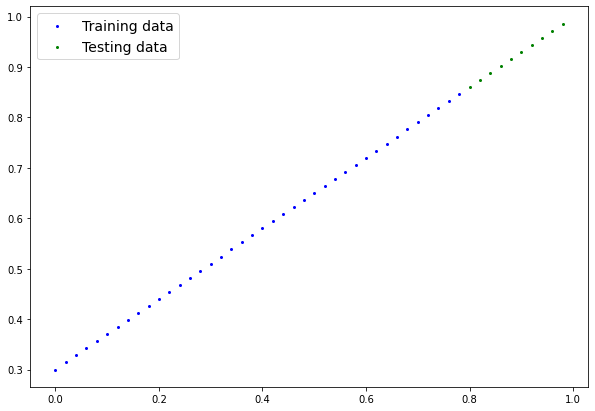

In [8]:
plot_predictions();

#  Build model

two methods to update parameters: 1. Gradient descent   2.Backprop

PyTorch model building essentials:
PyTorch has four (give or take) essential modules you can use to create almost any kind of neural network you can imagine.

### torch.nn	
->Contains all of the building blocks for computational graphs (essentially a series of computations executed in a particular way).

### torch.nn.Parameter	
->Stores tensors that can be used with nn.Module. If requires_grad=True gradients (used for updating model parameters via gradient descent) are calculated automatically, this is often referred to as "autograd".

### torch.nn.Module	
->The base class for all neural network modules, all the building blocks for neural networks are subclasses. If you're building a neural network in PyTorch, your models should subclass nn.Module. Requires a forward() method be implemented.

### torch.optim	
->Contains various optimization algorithms (these tell the model parameters stored in nn.Parameter how to best change to improve gradient descent and in turn reduce the loss).

### def forward()
->All nn.Module subclasses require a forward() method, this defines the computation that will take place on the data passed to the particular nn.Module (e.g. the linear regression formula above).

### torch.utils.data.Dataset
->Represemts a map between key(label) and sample(features) pairs of your data. 

### torch.utils.data.DataLoader
->Creates a Python iterable over a torch Dataset(allows you to iterate over your data).

![alt text](image.png)

In [9]:
import torch
from torch import nn
# Create a Linear Regression model class
class LinearRegressionModel(nn.Module): # <- almost everything in PyTorch is a nn.Module (think of this as neural network lego blocks)
    def __init__(self):#constructor  #check oop for python official link
        super().__init__() 
        self.weights = nn.Parameter(torch.randn(1, # <- start with random weights (this will get adjusted as the model learns)
                                                dtype=torch.float), # <- PyTorch loves float32 by default
                                   requires_grad=True) # <- can we update this value with gradient descent?)

        self.bias = nn.Parameter(torch.randn(1, # <- start with random bias (this will get adjusted as the model learns)
                                            dtype=torch.float), # <- PyTorch loves float32 by default
                                requires_grad=True) # <- can we update this value with gradient descent?))

    # Forward defines the computation in the model
    def forward(self, x: torch.Tensor) -> torch.Tensor: # <- "x" is the input data (e.g. training/testing features)
        return self.weights * x + self.bias # <- this is the linear regression formula (y = m*x + b)
    

# Checking the contents of a PyTorch model

In [10]:
# Set manual seed since nn.Parameter are randomly initialzied
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module that contains nn.Parameter(s))
model_0 = LinearRegressionModel()

# Check the nn.Parameter(s) within the nn.Module subclass we created
list(model_0.parameters())

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [11]:
# List named parameters 
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

# Making predictions using **torch.inference_mode()**

* torch.inference_mode() turns off a bunch of things (like gradient tracking, which is necessary for training but not for inference) to make forward-passes (data going through the forward() method) faster.

* Note: In older PyTorch code, you may also see torch.no_grad() being used for inference. While torch.inference_mode() and torch.no_grad() do similar things, torch.inference_mode() is newer, potentially faster and preferred.

In [12]:
# Make predictions with model
with torch.inference_mode(): 
    y_preds = model_0(X_test)

# Note: in older PyTorch code you might also see torch.no_grad()
# with torch.no_grad():
#   y_preds = model_0(X_test)

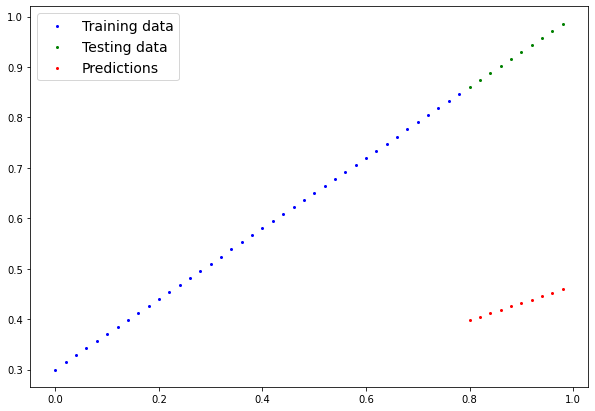

In [13]:
plot_predictions(predictions=y_preds)

#  Train model
* Loss functions-> PyTorch has plenty of built-in loss functions in torch.nn.
* Optimizer-> You can find various optimization function implementations in torch.optim.

 **params** is the target model parameters you'd like to optimize (e.g. the weights and bias values we randomly set before).
 
 The **learning rate** is considered a hyperparameter (because it's set by a machine learning engineer).Common starting values for the learning rate are 0.01, 0.001, 0.0001, however, these can also be adjusted over time (this is called learning rate scheduling)

In [14]:
# Create the loss function
loss_fn = nn.L1Loss() # MAE(Mean Absolute Error) loss is same as L1Loss

# Create the optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # parameters of target model to optimize
                            lr=0.01) # learning rate (how much the optimizer should change parameters at each step, higher=more (less stable), lower=less (might take a long time))

# Creating an optimization loop in PyTorch

| Number | Step name                          | What does it do?                                                                                      | Code example                         |
|--------|------------------------------------|-------------------------------------------------------------------------------------------------------|--------------------------------------|
| 1      | Forward pass                       | The model goes through all of the training data once, performing its forward() function calculations.  | `model(x_train)`                     |
| 2      | Calculate the loss                 | The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are. | `loss = loss_fn(y_pred, y_train)`    |
| 3      | Zero gradients                     | The optimizer's gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step. | `optimizer.zero_grad()`              |
| 4      | Perform backpropagation on the loss| Computes the gradient of the loss with respect to every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards". | `loss.backward()`                    |
| 5      | Update the optimizer (gradient descent) | Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them. | `optimizer.step()`                   |


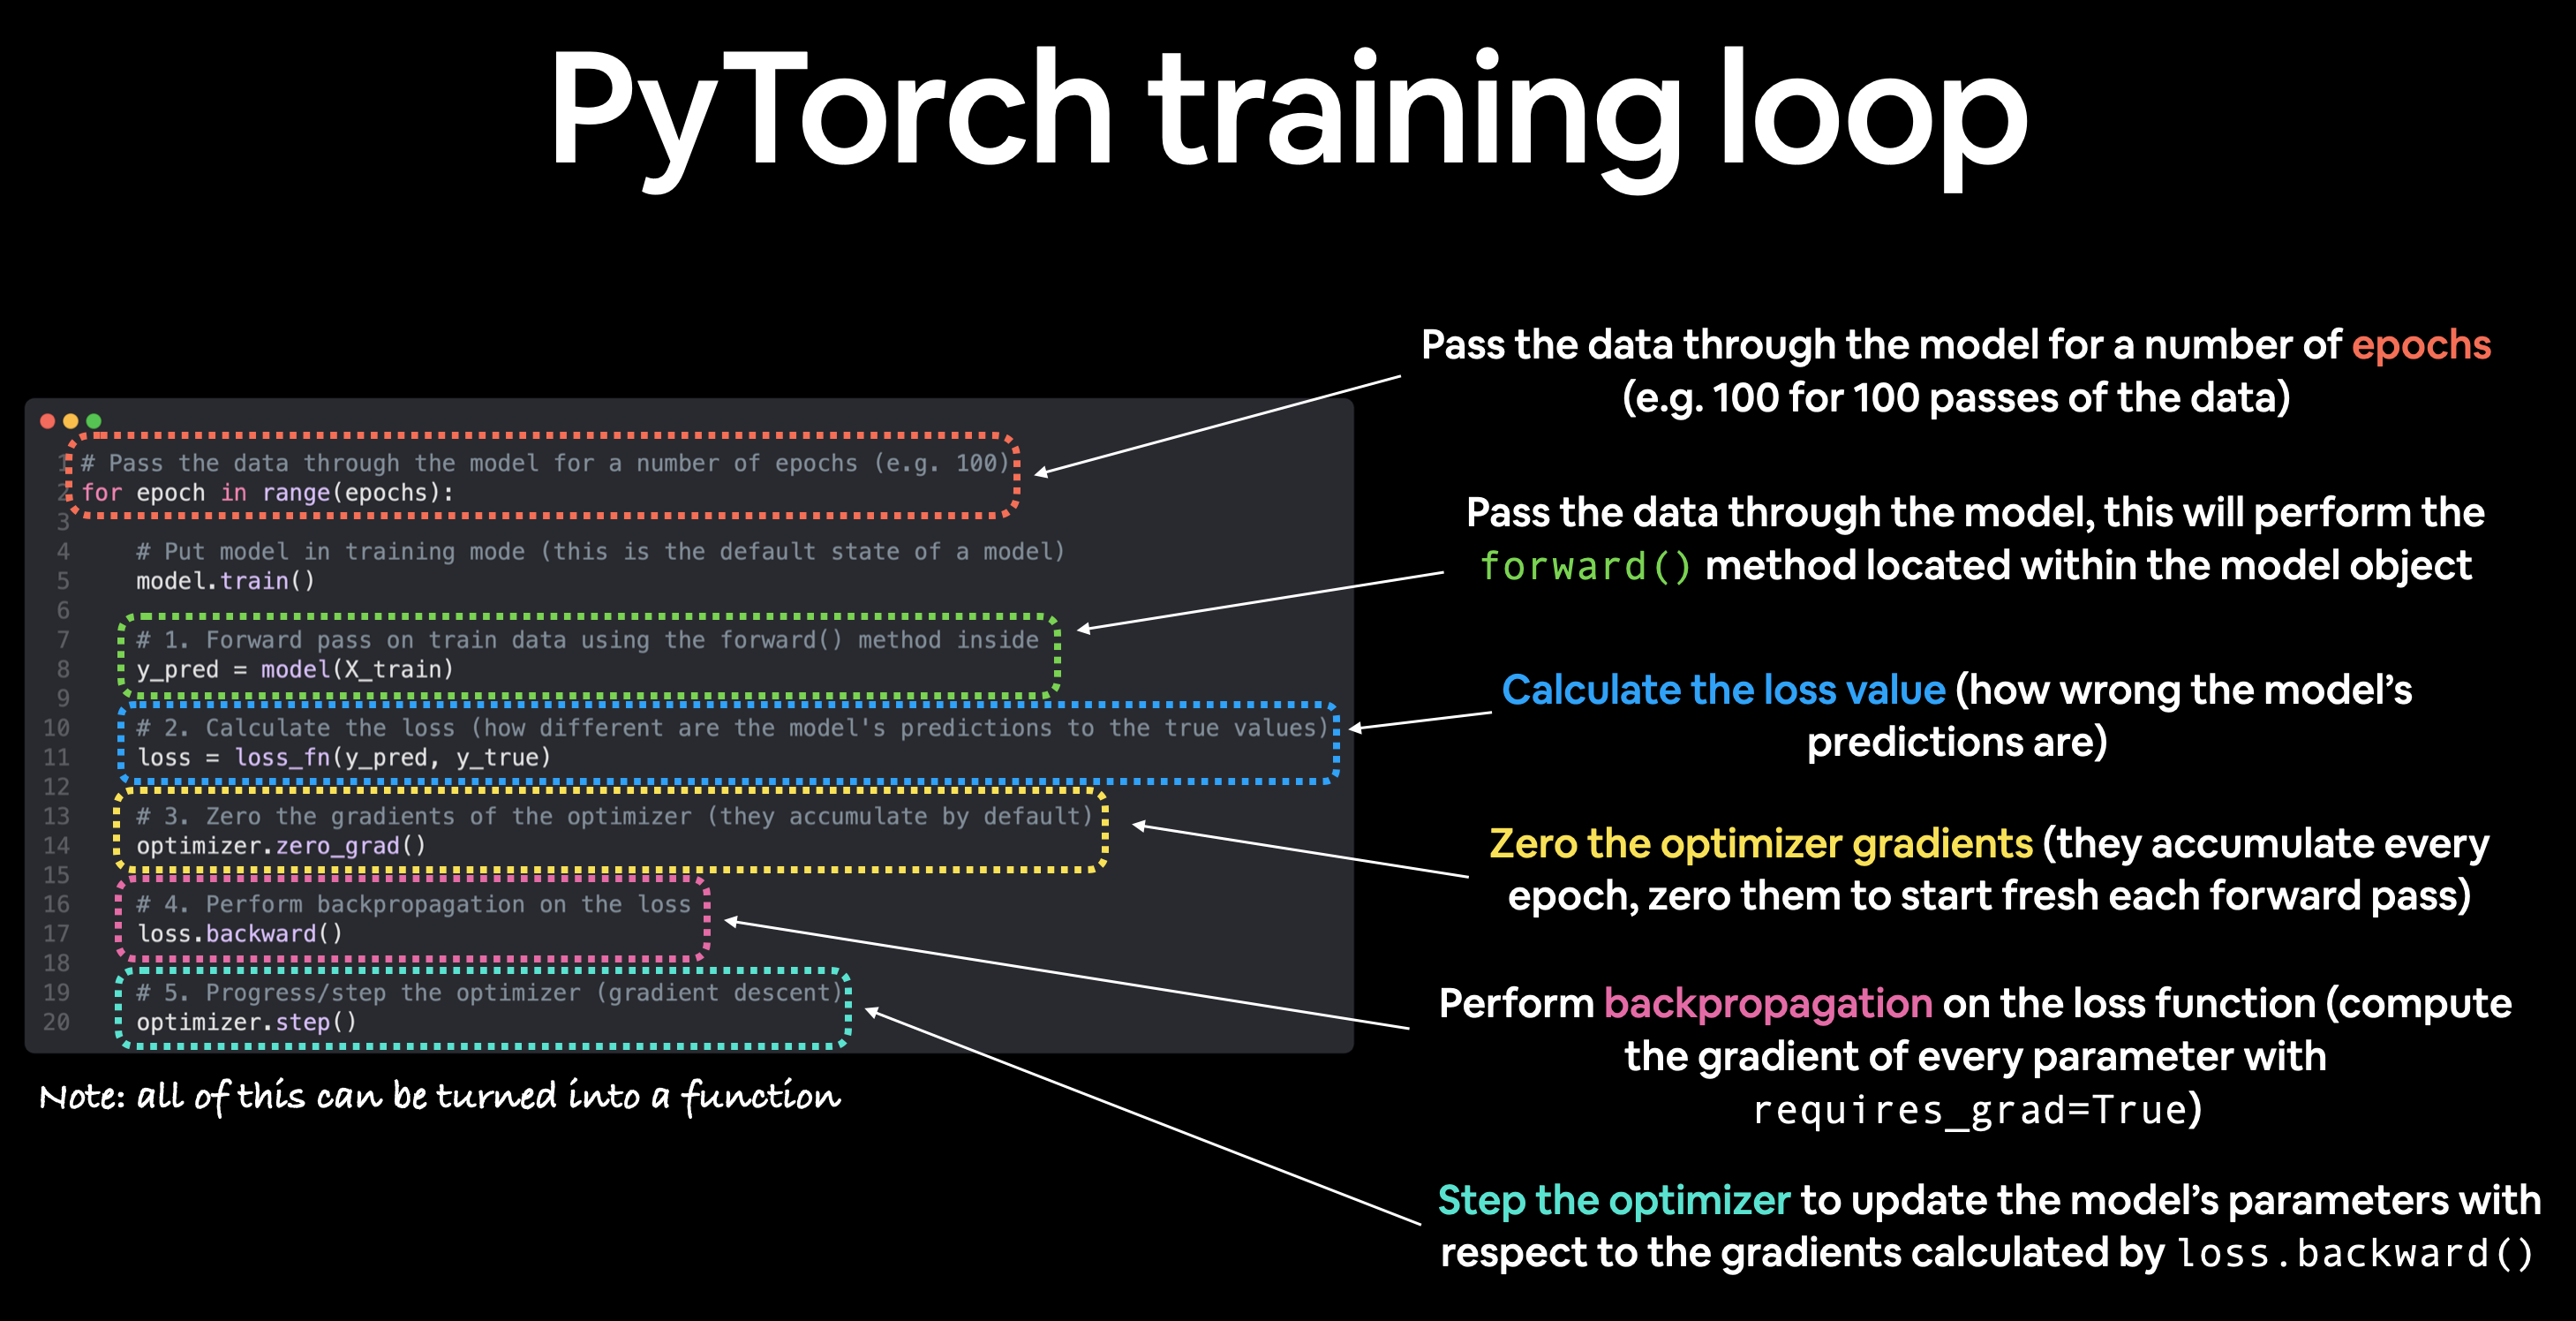

In [15]:

torch.manual_seed(42)

# Set the number of epochs (how many times the model will pass over the training data)
epochs = 200

# Create empty loss lists to track values
train_loss_values = []
test_loss_values = []
epoch_count = []
for epoch in range(epochs):
    ### Training

    # Put model in training mode (this is the default state of a model)
    model_0.train()

    # 1. Forward pass on train data using the forward() method inside 
    y_pred = model_0(X_train)
    # print(y_pred)

    # 2. Calculate the loss (how different are our models predictions to the ground truth)
    loss = loss_fn(y_pred, y_train)

    # 3. Zero grad of the optimizer
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Progress the optimizer(perform gradient descent)
    optimizer.step()# by default how the optimizer changes wil accumulate through the loop, we have to zero them in step 3 for the next iteration

    ### Testing

    # Put the model in evaluation mode
    model_0.eval()#turns off different setting in the model not needed for evaluation/testing(like bacth norm/dropout layers)

    with torch.inference_mode():#turns off gradient tracking
      # 1. Forward pass on test data
      test_pred = model_0(X_test)

      # 2. Caculate loss on test data
      test_loss = loss_fn(test_pred, y_test.type(torch.float)) # predictions come in torch.float datatype, so comparisons need to be done with tensors of the same type

      # Print out what's happening
      if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())#as it was tensor earlier and we can't plot it with matplot
            test_loss_values.append(test_loss.detach().numpy())
            print(f"Epoch: {epoch} | MAE Train Loss: {loss} | MAE Test Loss: {test_loss} ")

Epoch: 0 | MAE Train Loss: 0.31288138031959534 | MAE Test Loss: 0.48106518387794495 
Epoch: 10 | MAE Train Loss: 0.1976713240146637 | MAE Test Loss: 0.3463551998138428 
Epoch: 20 | MAE Train Loss: 0.08908725529909134 | MAE Test Loss: 0.21729660034179688 
Epoch: 30 | MAE Train Loss: 0.053148526698350906 | MAE Test Loss: 0.14464017748832703 
Epoch: 40 | MAE Train Loss: 0.04543796554207802 | MAE Test Loss: 0.11360953003168106 
Epoch: 50 | MAE Train Loss: 0.04167863354086876 | MAE Test Loss: 0.09919948130846024 
Epoch: 60 | MAE Train Loss: 0.03818932920694351 | MAE Test Loss: 0.08886633068323135 
Epoch: 70 | MAE Train Loss: 0.03476089984178543 | MAE Test Loss: 0.0805937647819519 
Epoch: 80 | MAE Train Loss: 0.03132382780313492 | MAE Test Loss: 0.07232122868299484 
Epoch: 90 | MAE Train Loss: 0.02788739837706089 | MAE Test Loss: 0.06473556160926819 
Epoch: 100 | MAE Train Loss: 0.024458957836031914 | MAE Test Loss: 0.05646304413676262 
Epoch: 110 | MAE Train Loss: 0.021020207554101944 | MAE

# Making predictions with a trained PyTorch model (inference)

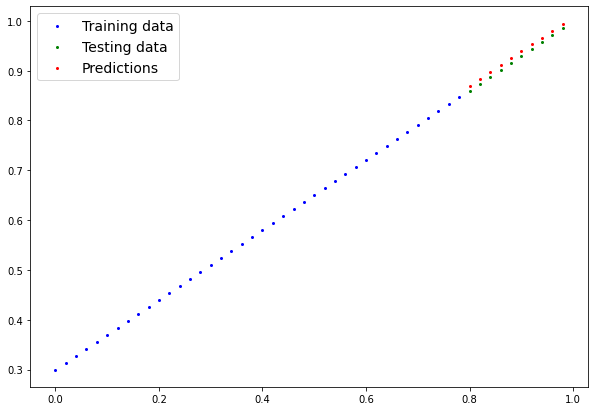

In [16]:
plot_predictions(predictions=test_pred)

with 100 epochs
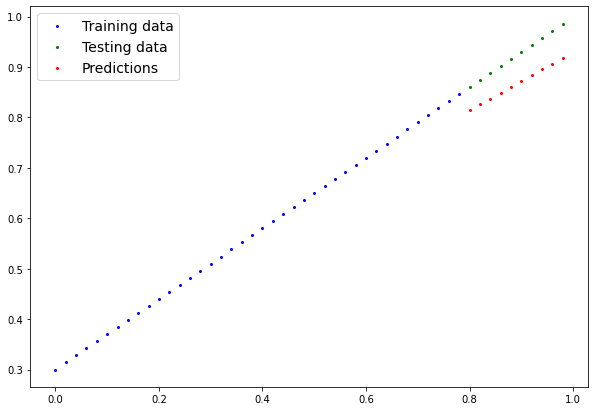

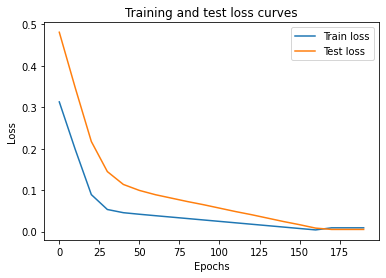

In [17]:
# Plot the loss curves
plt.plot(epoch_count, train_loss_values, label="Train loss")
plt.plot(epoch_count, test_loss_values, label="Test loss")
plt.title("Training and test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend();

with 100 epochs
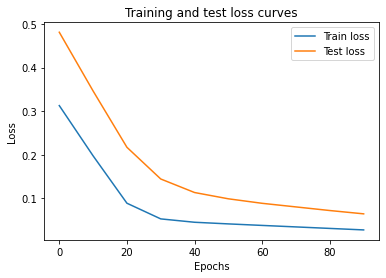

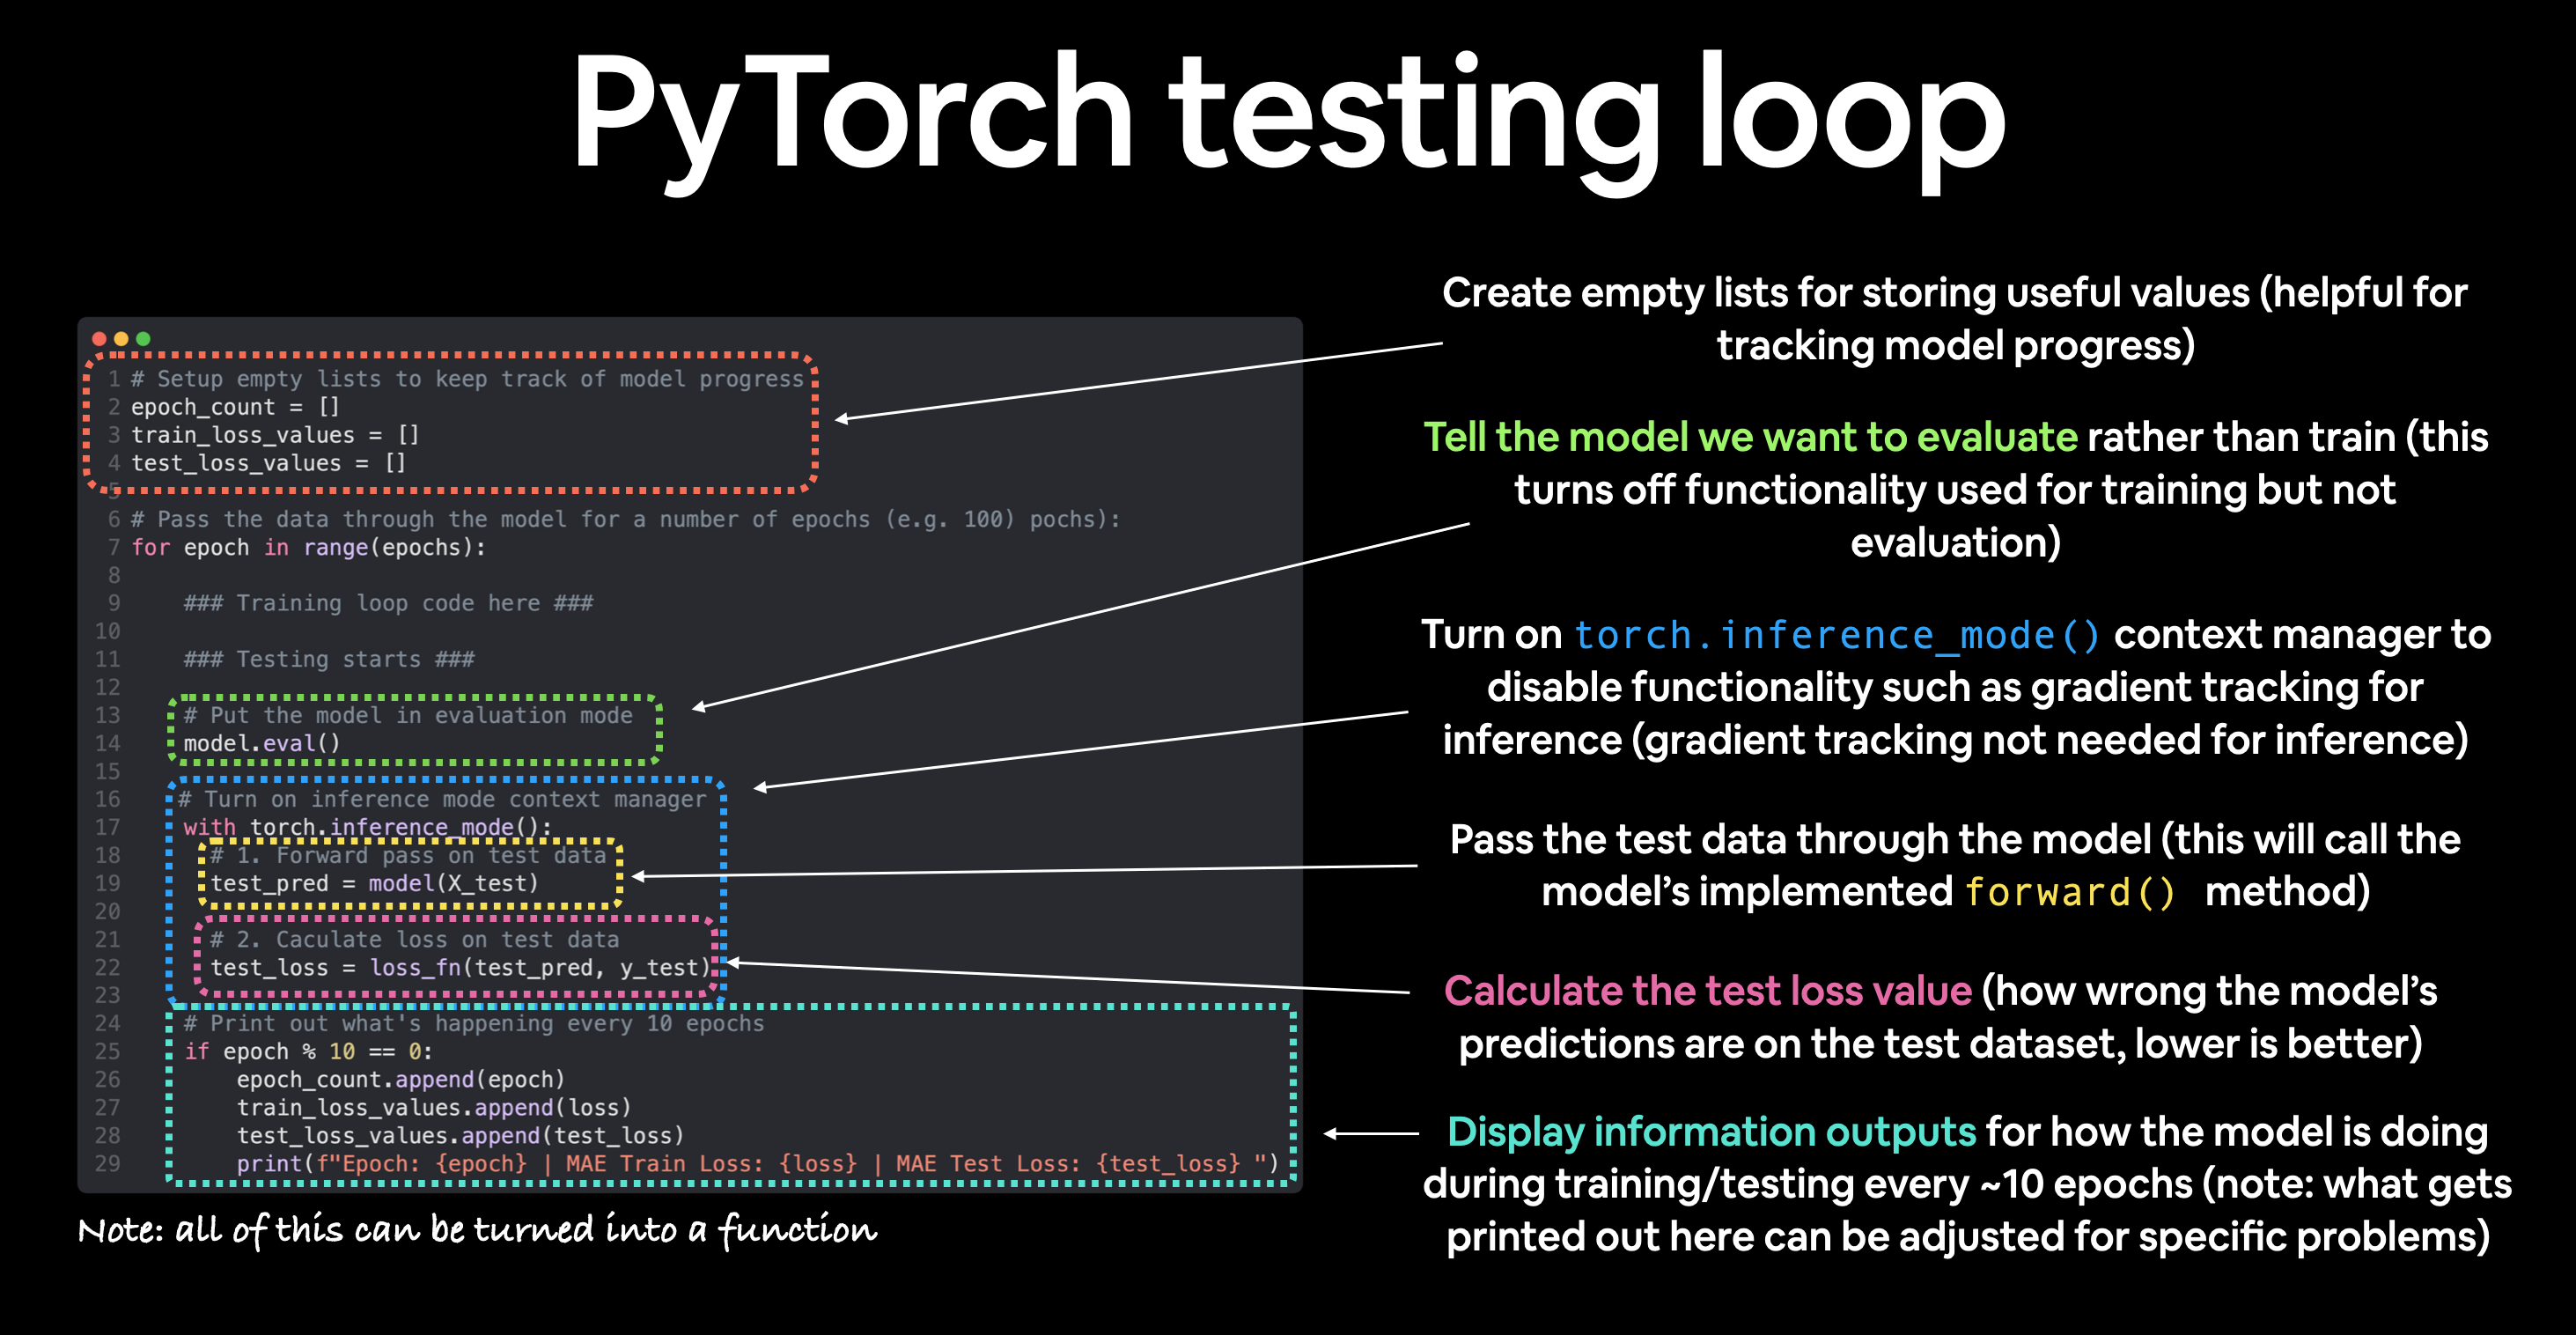

# Saving and loading a PyTorch model

`torch.save:` Saves a serialized object to disk. This function uses Python’s pickle utility for serialization. Models, tensors, and dictionaries of all kinds of objects can be saved using this function.

`torch.load: `Uses pickle’s unpickling facilities to deserialize pickled object files to memory. This function also facilitates the device to load the data into (see Saving & Loading Model Across Devices).

`torch.nn.Module.load_state_dict:` Loads a model’s parameter dictionary using a deserialized state_dict. For more information on state_dict, see What is a state_dict?.

`state_dict : `
In PyTorch, the learnable parameters (i.e. weights and biases) of an torch.nn.Module model are contained in the model’s parameters (accessed with model.parameters()). A state_dict is simply a Python dictionary object that maps each layer to its parameter tensor. Note that only layers with learnable parameters (convolutional layers, linear layers, etc.) and registered buffers (batchnorm’s running_mean) have entries in the model’s state_dict. Optimizer objects (torch.optim) also have a state_dict, which contains information about the optimizer’s state, as well as the hyperparameters used.

In [18]:
# Find our model's learned parameters
print("The model learned the following values for weights and bias:")
print(model_0.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.6990])), ('bias', tensor([0.3093]))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


# Saving & Loading Model for Inference

 ## Save state_dict (Recommended)

In [19]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path 
MODEL_NAME="01_pytorch_workflow_model_0.pth"
MODEL_SAVE_PATH=MODEL_PATH/MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to:{MODEL_SAVE_PATH}")
torch.save(obj=model_0.state_dict(),# only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to:models/01_pytorch_workflow_model_0.pth


In [20]:
!ls -l models/01_pytorch_workflow_model_0.pth

-rw-rw-r-- 1 shatakshig shatakshig 1063 May 25 15:27 models/01_pytorch_workflow_model_0.pth


## Loading a saved PyTorch model's state_dict()

In [21]:
# Instantiate a new instance of our model (this will be instantiated with random weights)
loaded_model_0 = LinearRegressionModel()

#torch.nn.Module.load_state_dict(torch.load(f)) , loaded_model_0 is torch.nn.Module
# Load the state_dict of our saved model (this will update the new instance of our model with trained weights)
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

<All keys matched successfully>

* PyTorch inference rules:
Set the model in evaluation mode (model.eval()).
Make the predictions using the inference mode context manager (with torch.inference_mode(): ...).
All predictions should be made with objects on the same device (e.g. data and model on GPU only or data and model on CPU only).

In [22]:
# 1. Put the loaded model into evaluation mode
loaded_model_0.eval()

# 2. Use the inference mode context manager to make predictions
with torch.inference_mode():
    loaded_model_preds = loaded_model_0(X_test) # perform a forward pass on the test data with the loaded model

model_0.eval()
with torch.inference_mode():
    y_preds = model_0(X_test)
    
# Compare previous model predictions with loaded model predictions (these should be the same)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])

* ## Save/Load Entire Model
Save:
torch.save(model, PATH)


Load:
Model class must be defined somewhere

model = torch.load(PATH)
model.eval()

# Putting it all together

## Data

In [23]:
import torch
from torch import nn
import matplotlib.pyplot as plt

torch.__version__

'1.10.2+cu111'

## Device Agnostic Code

In [24]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [25]:
weight=0.7
bias=0.3

start=0
end=1
step=0.02

X= torch.arange(start, end, step).unsqueeze(dim=1)# without unsqueeze, errors will happen later on (shapes within linear layers)
y= weight*X + bias

X[:5] , y[:5]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560]]))

## Split

In [26]:
split=int(0.8*len(X))
X_train=X[:split]
X_test=X[split:]
y_train=y[:split]
y_test=y[split:]
len(X_train) ,len(X_test) ,len(y_train) ,len(y_test)

(40, 10, 40, 10)

## Plot

In [27]:
def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
    plt.figure(figsize=(10,7))

    plt.scatter(train_data , train_labels , c="b", s=4 , label="Training data")
    plt.scatter(test_data ,test_labels , c="g" , s=4 , label="Testing data")

    if predictions is not None:
        plt.scatter(test_data , predictions, c="r", s=4 , label="Predictions")

    plt.legend(prop={"size": 14})

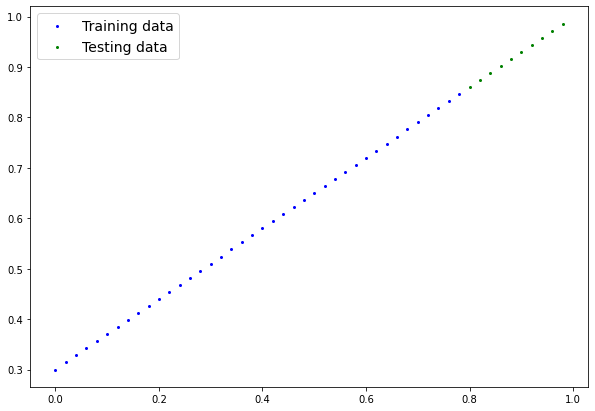

In [28]:
# Note: If you've reset your runtime, this function won't work, 
# you'll have to rerun the cell above where it's instantiated.
plot_predictions(X_train, y_train, X_test, y_test)

## Build Model

Explanation:

**Class Definition (class LinearRegressionModelV2(nn.Linear):):**

This line defines a new class named LinearRegressionModelV2 that inherits from nn.Linear. The nn.Linear class is a built-in PyTorch class that implements a linear transformation to the incoming data: 
𝑦=𝑥𝐴^𝑇+𝑏, where 𝑥 is the input, 𝐴 is the weight matrix, and 𝑏 is the bias.


**Constructor Method (def __init__(self):):**

The __init__ method is the constructor method in Python classes. It is called when an instance (object) of the class is created.


**Calling the Superclass Constructor (super().__init__()):**

super().__init__() calls the constructor of the superclass (nn.Linear) to ensure that all the initialization required for nn.Linear is also done for LinearRegressionModelV2. This is crucial because it sets up the necessary attributes and parameters that nn.Linear needs to function properly.

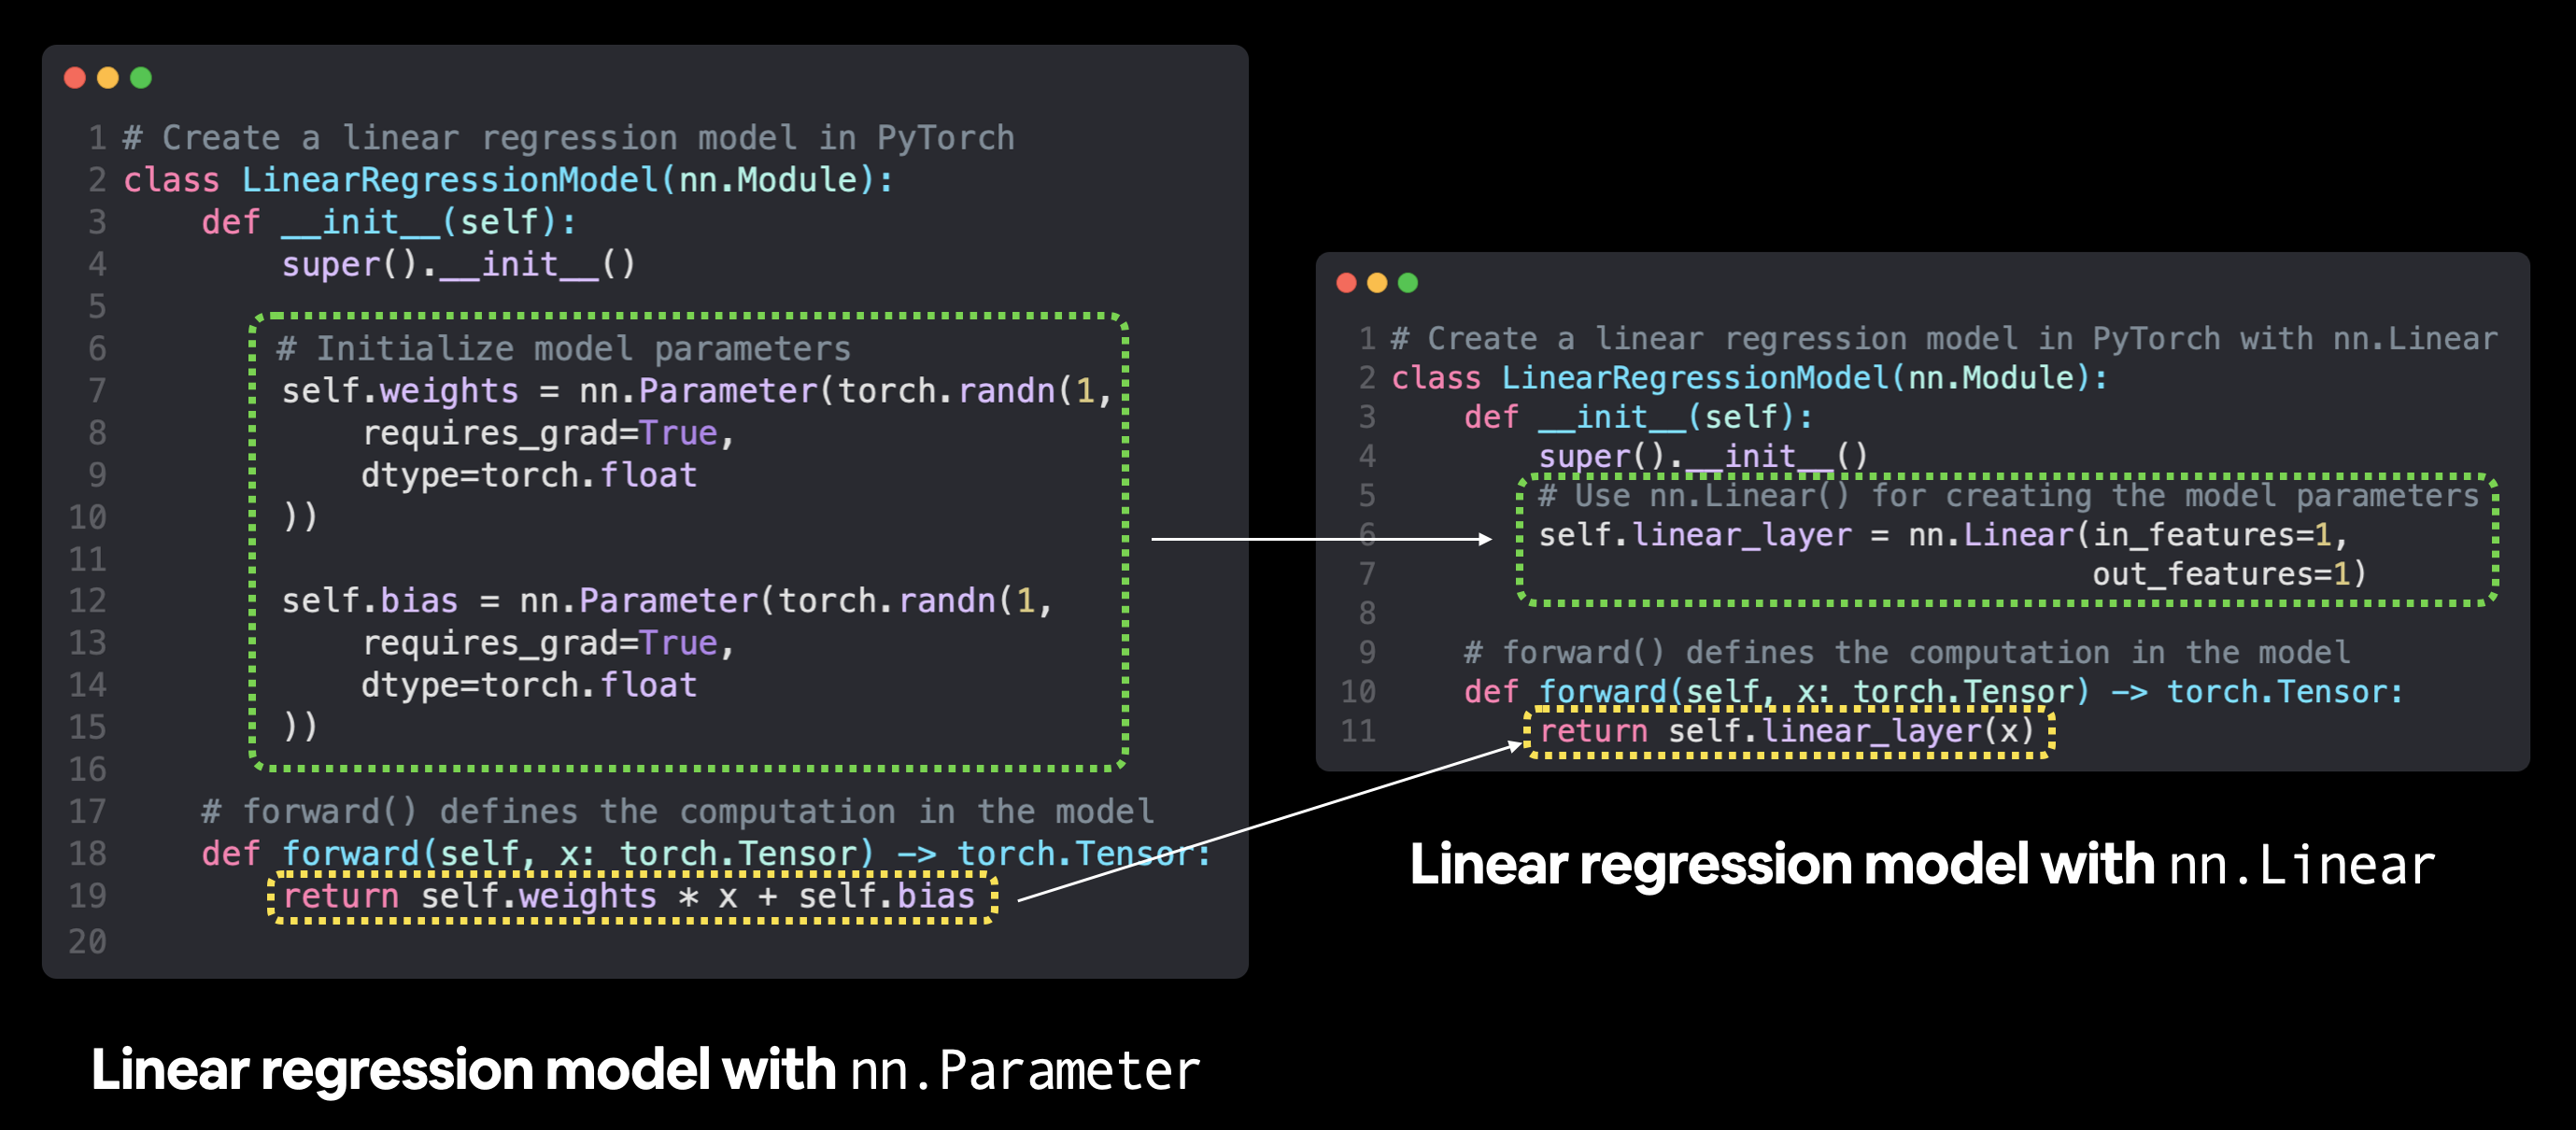

In [29]:
# Subclass nn.Module to make our model
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        # Use nn.Linear() for creating the model parameters
        self.linear_layer=nn.Linear(in_features=1 ,
                                    out_features=1)
    
    # Define the forward computation (input data x flows through nn.Linear())
    def forward(self, x: torch.tensor)->torch.tensor:
        return self.linear_layer(x)
    
# Set the manual seed when creating the model (this isn't always need but is used for demonstrative purposes, try commenting it out and seeing what happens)
torch.manual_seed(42)
model_1=LinearRegressionModelV2()
model_1 , model_1.state_dict()
#Notice the outputs of model_1.state_dict(), the nn.Linear() layer created a random weight and bias parameter for us.

(LinearRegressionModelV2(
   (linear_layer): Linear(in_features=1, out_features=1, bias=True)
 ),
 OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
              ('linear_layer.bias', tensor([0.8300]))]))

## Model to(device)

In [30]:
# Check model device
next(model_1.parameters()).device

device(type='cpu')

**next(model_1.parameters()):**

The next() function retrieves the next item from the iterator. Since **model_1.parameters()** returns an iterator over the model's parameters, next(model_1.parameters()) fetches the first parameter tensor from this iterator. This is typically the first layer's weight tensor in the model.

In [31]:
model_1.to(device)
next(model_1.parameters()).device

device(type='cuda', index=0)

## Loss fn / Optimizer

In [32]:
loss_fn= nn.L1Loss()
optimizer=torch.optim.SGD(params=model_1.parameters(),# optimize newly created model's parameters
                           lr=0.01)

## Train /Test Model

In [33]:
torch.manual_seed(42)
epochs=200

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)


for epoch in range(epochs):
     ### Training
    model_1.train()# train mode is on by default after construction
    
    # 1. Forward pass
    y_pred=model_1(X_train)
    
    # 2. Calculate loss
    loss=loss_fn(y_pred, y_train)
    
    # 3. Zero grad optimizer
    optimizer.zero_grad()
    
    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model_1.eval()# put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred=model_1(X_test)
        test_loss= loss_fn(test_pred,y_test)
    
    if epoch%10==0:
        print(f"Epoch : {epoch} | MAE(train) Loss : {loss} | Test Loss: {test_loss}")

    

Epoch : 0 | MAE(train) Loss : 0.5552404522895813 | Test Loss: 0.5739867687225342
Epoch : 10 | MAE(train) Loss : 0.4400051534175873 | Test Loss: 0.4392254054546356
Epoch : 20 | MAE(train) Loss : 0.32476988434791565 | Test Loss: 0.30446407198905945
Epoch : 30 | MAE(train) Loss : 0.20953460037708282 | Test Loss: 0.16970273852348328
Epoch : 40 | MAE(train) Loss : 0.0942993313074112 | Test Loss: 0.034941405057907104
Epoch : 50 | MAE(train) Loss : 0.023888953030109406 | Test Loss: 0.04776671528816223
Epoch : 60 | MAE(train) Loss : 0.019958985969424248 | Test Loss: 0.045796602964401245
Epoch : 70 | MAE(train) Loss : 0.016532523557543755 | Test Loss: 0.03758838772773743
Epoch : 80 | MAE(train) Loss : 0.01310905534774065 | Test Loss: 0.02988019585609436
Epoch : 90 | MAE(train) Loss : 0.009654558263719082 | Test Loss: 0.021671921014785767
Epoch : 100 | MAE(train) Loss : 0.006228079553693533 | Test Loss: 0.013463765382766724
Epoch : 110 | MAE(train) Loss : 0.00278380885720253 | Test Loss: 0.00525

In [34]:
# Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html 
print("The model learned the following values for weights and bias:")
pprint(model_1.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('linear_layer.weight', tensor([[0.6918]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.2975], device='cuda:0'))])

And the original values for weights and bias are:
weights: 0.7, bias: 0.3


## Making Predictions

In [35]:
# Turn model into evaluation mode
model_1.eval()

# Make predictions on the test data
with torch.inference_mode():
    y_preds = model_1(X_test)
y_preds

tensor([[0.8509],
        [0.8647],
        [0.8786],
        [0.8924],
        [0.9063],
        [0.9201],
        [0.9340],
        [0.9478],
        [0.9617],
        [0.9756]], device='cuda:0')

## Visualize

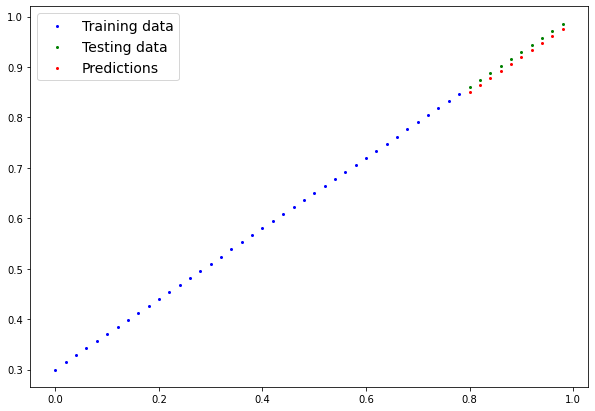

In [37]:
# plot_predictions(predictions=y_preds) # -> won't work... data not on CPU

# Put data on the CPU and plot it
plot_predictions(predictions=y_preds.cpu())

## Save

In [38]:
from pathlib import Path

# 1. Create models directory 
MODEL_PATH = Path("models")

# 2. Create model save path 
MODEL_NAME = "01_pytorch_workflow_model_1.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict 
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH) 

Saving model to: models/01_pytorch_workflow_model_1.pth


## Load

In [39]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model_1 = LinearRegressionModelV2()

# Load model state dict 
loaded_model_1.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model_1.to(device)

print(f"Loaded model:\n{loaded_model_1}")
print(f"Model on device:\n{next(loaded_model_1.parameters()).device}")

Loaded model:
LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
Model on device:
cuda:0


In [40]:
# Evaluate loaded model
loaded_model_1.eval()
with torch.inference_mode():
    loaded_model_1_preds = loaded_model_1(X_test)
y_preds == loaded_model_1_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]], device='cuda:0')